# Programming assignment 7: SVM

In [41]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

from cvxopt import matrix, solvers

## Your task

In this sheet we will implement a simple binary SVM classifier.

We will use **`CVXOPT`** http://cvxopt.org/ - a Python library for convex optimization. If you use `Anaconda`, you can install it using

    conda install cvxopt
    
As usual, your task is to fill out the missing code, run the notebook, convert it to PDF and attach it you your HW solution.

## Generate and visualize the data

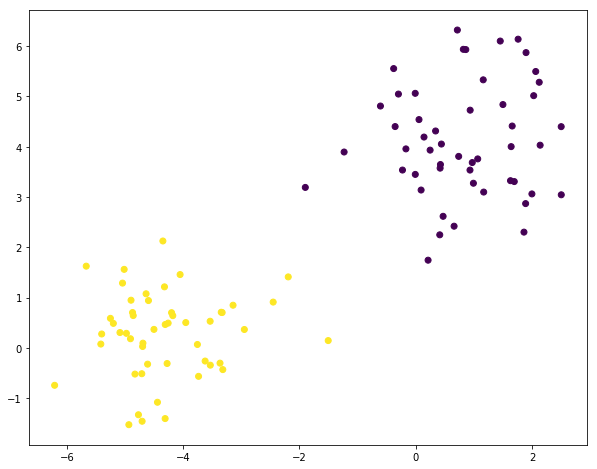

In [104]:
N = 100  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 3  # for reproducible experiments

X, y = make_blobs(n_samples=N, n_features=D, centers=2, random_state=seed)
y[y == 0] = -1  # it is more convenient to have {-1, 1} as class labels (instead of {0, 1})
y = y.astype(np.float)
plt.figure(figsize=[10, 8])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Task 1: Solving the SVM dual problem

Remember, that the SVM dual problem can be formulated as a Quadratic programming (QP) problem.
We will solve it using a QP solver from the `CVXOPT` library.

The general form of a QP is
$$\min_{\mathbf{x}} \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x}$$

$$\text{subject to } \quad \mathbf{G}\mathbf{x} \preceq \mathbf{h}$$

$$\text{and } \quad \mathbf{A}\mathbf{x} = \mathbf{b}$$

where $\preceq$ denotes "elementwise less than or equal to".

**Your task** is to formulate the SVM dual problems as a QP and solve it using `CVXOPT`, i.e. specify the matrices $\mathbf{P}, \mathbf{G}, \mathbf{A}$ and vectors $\mathbf{q}, \mathbf{h}, \mathbf{b}$.

In [105]:
def solve_dual_svm(X, y):
    """Solve the dual formulation of the SVM problem.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    alphas : array, shape [N]
        Solution of the dual problem.
    """
    # TODO
    # These variables have to be of type cvxopt.matrix
    P = matrix(np.dot(X, X.T) * y[None, :] * y[:, None])
    q = matrix(-np.ones(shape=(N, 1)))
    G = matrix(-np.eye(N))
    h = matrix(-np.zeros(shape=(N,1)))
    A = matrix(y[None, :])
    b = matrix(0.0)
    
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    return alphas

## Task 2: Recovering the weights and the bias

In [106]:
def compute_weights_and_bias(alpha, X, y):
    """Recover the weights w and the bias b using the dual solution alpha.
    
    Parameters
    ----------
    alpha : array, shape [N]
        Solution of the dual problem.
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    w = np.dot(X.T, alpha * y[:, None])
    idx_sv = np.where(alpha > 1e-4)[0][0]
    b = y[idx_sv] - np.dot(X[idx_sv, :], w)
    return w, b

## Visualize the result (nothing to do here)

In [107]:
def plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b):
    """Plot the data as a scatter plot together with the separating hyperplane.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    alpha : array, shape [N]
        Solution of the dual problem.
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    plt.figure(figsize=[10, 8])
    # Plot the hyperplane
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.linspace(X[:, 0].min(), X[:, 0].max())
    plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
    m = 2./ np.linalg.norm(w)
    plt.plot(x, x * slope + intercept + 0.5*m, '-', c='red', label='margin')
    plt.plot(x, x * slope + intercept - 0.5*m, '-', c='red')
    plt.fill_between(x, x * slope + intercept, x * slope + intercept + 0.5*m, facecolor='red', alpha=0.15)
    plt.fill_between(x, x * slope + intercept, x * slope + intercept - 0.5*m, facecolor='red', alpha=0.15)
    # Plot all the datapoints
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # Mark the support vectors
    support_vecs = (alpha > 1e-4).reshape(-1)
    plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')

The reference solution is

    w = array([[-0.69192638],
               [-1.00973312]])
    
    b = 0.907667782

Indices of the support vectors are
    
    [38, 47, 92]

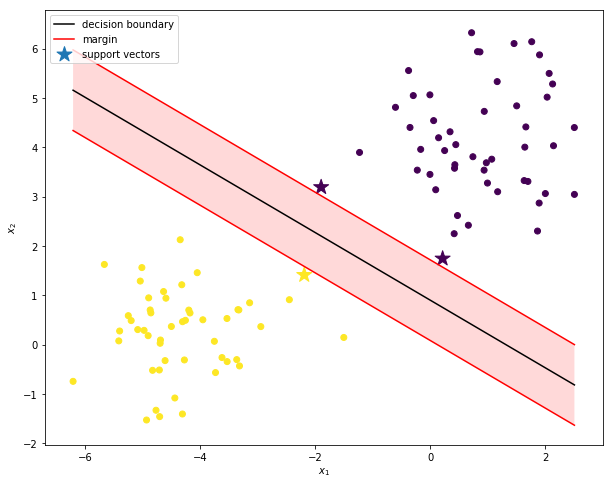

weights w = 
 [[-0.69192638]
 [-1.00973312]] 
 bias b = 
 [ 0.90766782]
Indices of the support vectors are [38 47 92]


In [108]:
alpha = solve_dual_svm(X, y)
w, b = compute_weights_and_bias(alpha, X, y)
plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b)
plt.show()
print('weights w = \n {} \n bias b = \n {}'.format(w, b))
print('Indices of the support vectors are {}'.format(np.where(alpha > 1e-4)[0]))